In [2]:
import pandas as pd
# 저희는 Tabular Data를 다루기 때문에 아래 라이브러리를 호출합니다.
from autogluon.tabular import TabularDataset, TabularPredictor
import numpy as np
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt


c:\ProgramData\anaconda3\envs\autog\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
bnum=54
drop_col = ['week', 'CDH',  'THI', 'max_power', 'min_power']
train54 = pd.read_csv(f'./submit/train_building{bnum}.csv').drop(columns=drop_col)

pretrain54 = pd.read_csv(f'./pretest/train_building{bnum}.csv').drop(columns=drop_col)
pretest54 = pd.read_csv(f'./pretest/pretest_building{bnum}.csv').drop(columns=drop_col)


In [16]:
pretrain = TabularDataset(pretrain54)
pretest = TabularDataset(pretest54)

In [17]:
predictor = TabularPredictor(label='power_consumption', eval_metric='mean_squared_error',).fit(pretrain)

No path specified. Models will be saved in: "AutogluonModels\ag-20230824_124327\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230824_124327\"
AutoGluon Version:  0.8.2
Python Version:     3.8.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   41.94 GB / 499.43 GB (8.4%)
Train Data Rows:    1872
Train Data Columns: 18
Label Column: power_consumption
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3766.68, 371.88, 1807.77933, 1121.50385)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available M

In [18]:
ld_board = predictor.leaderboard(pretrain, silent=True)

ld_board

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge,-10658.716746,-44019.958421,0.045877,0.003990,1.459100,0.045877,0.003990,1.459100,1,True,11
1,ExtraTreesMSE,-12702.346979,-40140.926177,0.090756,0.045877,0.556512,0.090756,0.045877,0.556512,1,True,7
2,RandomForestMSE,-12980.976456,-41194.485990,0.107712,0.045878,0.780912,0.107712,0.045878,0.780912,1,True,5
3,XGBoost,-13584.370027,-38031.198822,0.025931,0.002992,0.491685,0.025931,0.002992,0.491685,1,True,9
4,LightGBM,-18242.473592,-40856.306205,0.023936,0.002992,0.586432,0.023936,0.002992,0.586432,1,True,4
5,CatBoost,-20738.368510,-33131.762120,0.013963,0.003990,1.389304,0.013963,0.003990,1.389304,1,True,6
6,WeightedEnsemble_L2,-21209.444158,-32869.833208,0.141623,0.025932,11.692864,0.013963,0.000000,0.330223,2,True,12
7,LightGBMXT,-25143.600988,-40064.607189,0.033910,0.005984,0.828783,0.033910,0.005984,0.828783,1,True,3
8,KNeighborsDist,-27806.643581,-138810.764651,0.012965,0.004987,0.005983,0.012965,0.004987,0.005983,1,True,2
9,NeuralNetFastAI,-34769.333657,-40108.976215,0.053856,0.009974,1.850053,0.053856,0.009974,1.850053,1,True,8


In [19]:
# 가장 우수한 모델의 이름을 가져옵니다.
best_model_name = predictor.get_model_best()

# 가장 우수한 모델로 예측 수행
predictions = predictor.predict(pretest, model=best_model_name)

# 예측 결과 출력
print(predictions)

0       729.696411
1       647.223389
2       653.508545
3       607.679443
4       605.969727
          ...     
163    2144.856689
164    1650.781738
165     957.769531
166     889.825195
167     932.610535
Name: power_consumption, Length: 168, dtype: float32


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='power_consumption'>)

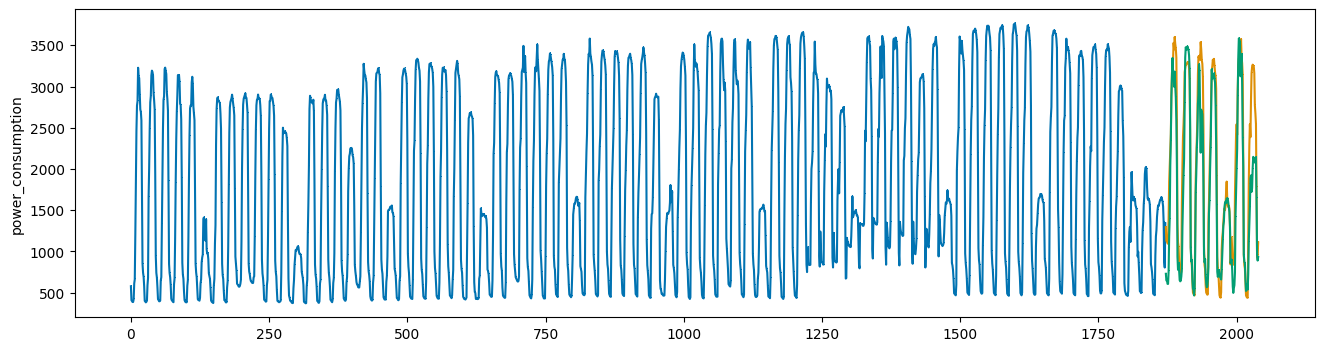

In [22]:

pretrain54_y = pretrain54['power_consumption']
test54_y = pretest54['power_consumption']
l = len(pretrain54_y)

predictions.index = np.arange(pretest54.index[0]+l, pretest54.index[-1]+1+l)
test54_y.index = np.arange(pretest54.index[0]+l, pretest54.index[-1]+1+l)
plot_series(pretrain54_y, test54_y, pd.Series(predictions), markers=[',' , ',', ','])

In [23]:

def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))


In [25]:
y_test_np = pretest54['power_consumption']
score = SMAPE(y_test_np, predictions)
print(score)

19.169899919339187


제출용

In [26]:
i = 54
train_df = pd.read_csv(f'./submit/train_building{i}.csv')
test_df = pd.read_csv(f'./submit/test_building{i}.csv')

train = TabularDataset(train_df)
test = TabularDataset(test_df)

predictor = TabularPredictor(label='power_consumption', eval_metric='mean_squared_error',).fit(train)

ld_board = predictor.leaderboard(train, silent=True)

ld_board

No path specified. Models will be saved in: "AutogluonModels\ag-20230824_124624\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230824_124624\"
AutoGluon Version:  0.8.2
Python Version:     3.8.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   41.86 GB / 499.43 GB (8.4%)
Train Data Rows:    2040
Train Data Columns: 23
Label Column: power_consumption
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (3766.68, 371.88, 1824.23038, 1118.50446)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available M

[1000]	valid_set's l2: 26043
[2000]	valid_set's l2: 25170.9
[3000]	valid_set's l2: 24968.9
[4000]	valid_set's l2: 25008.2


	-24940.1744	 = Validation score   (-mean_squared_error)
	4.15s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's l2: 31702.3


	-31591.6815	 = Validation score   (-mean_squared_error)
	1.6s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-45683.7602	 = Validation score   (-mean_squared_error)
	1.16s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	-24265.1872	 = Validation score   (-mean_squared_error)
	20.46s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-44066.9368	 = Validation score   (-mean_squared_error)
	0.59s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-38430.3384	 = Validation score   (-mean_squared_error)
	2.41s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: XGBoost ...
	-45116.0117	 = Validation score   (-mean_squared_error)
	1.04s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-38058.4017	 = Validation score   (-mean_squared_error)
	16.78s	 = Training   runtime
	0.01s	 = Validation runtime
Fit

[1000]	valid_set's l2: 36805.8


	-36799.9027	 = Validation score   (-mean_squared_error)
	2.91s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-23369.7144	 = Validation score   (-mean_squared_error)
	0.32s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 52.4s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels\ag-20230824_124624\")


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,CatBoost,-5032.525616,-24265.187209,0.017950,0.002993,20.460248,0.017950,0.002993,20.460248,1,True,6
1,WeightedEnsemble_L2,-5040.373628,-23369.714425,0.235369,0.038868,41.712159,0.008975,0.000968,0.320145,2,True,12
2,LightGBMXT,-5235.546784,-24940.174382,0.180518,0.025931,4.147911,0.180518,0.025931,4.147911,1,True,3
3,LightGBM,-6414.932040,-31591.681451,0.099734,0.008976,1.600721,0.099734,0.008976,1.600721,1,True,4
4,LightGBMLarge,-7360.689093,-36799.902687,0.093750,0.011969,2.914209,0.093750,0.011969,2.914209,1,True,11
5,XGBoost,-9099.091869,-45116.011726,0.085770,0.006981,1.035233,0.085770,0.006981,1.035233,1,True,9
6,ExtraTreesMSE,-12518.869234,-44066.936833,0.115690,0.045878,0.594411,0.115690,0.045878,0.594411,1,True,7
7,RandomForestMSE,-13313.358856,-45683.760204,0.112700,0.046875,1.157904,0.112700,0.046875,1.157904,1,True,5
8,KNeighborsDist,-21655.851498,-108279.257475,0.015956,0.004987,0.007978,0.015956,0.004987,0.007978,1,True,2
9,NeuralNetTorch,-24430.124359,-38058.401744,0.027926,0.008976,16.783855,0.027926,0.008976,16.783855,1,True,10


In [3]:
bnum=[39]
drop_col=['week', 'CDH',  'THI', 'max_power', 'min_power']
for i in bnum:
    train_df = pd.read_csv(f'./submit/train_building{i}.csv').drop(columns=drop_col)
    test_df = pd.read_csv(f'./submit/test_building{i}.csv').drop(columns=drop_col)

    train = TabularDataset(train_df)
    test = TabularDataset(test_df)

    predictor = TabularPredictor(label='power_consumption', eval_metric='mean_squared_error',).fit(train)

    # 가장 우수한 모델의 이름을 가져옵니다.
    best_model_name = predictor.get_model_best()

    # 가장 우수한 모델로 예측 수행
    predictions = predictor.predict(test, model=best_model_name)
#     subm = pd.read_csv('./submission\ensemble_wsw_clust75_05_2.csv')

#     for idx, value in predictions.items():
#         subm.loc[idx, 'answer'] = value


# subm.to_csv('./submission/ensemble_autog_54_33.csv', index = False)

No path specified. Models will be saved in: "AutogluonModels\ag-20230824_163328\"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20230824_163328\"
AutoGluon Version:  0.8.2
Python Version:     3.8.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
Disk Space Avail:   64.57 GB / 499.43 GB (12.9%)
Train Data Rows:    2040
Train Data Columns: 18
Label Column: power_consumption


Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (4062.24, 476.16, 2170.46635, 1379.5717)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    4385.48 MB
	Train Data (Original)  Memory Usage: 0.29 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain 2 unique values.
	Stage 2 Generators:
		Fitting FillNaFeatureGenerator...
	St

[1000]	valid_set's l2: 43287
[2000]	valid_set's l2: 41956.8


	-41762.6472	 = Validation score   (-mean_squared_error)
	3.59s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: LightGBM ...
	-50913.0485	 = Validation score   (-mean_squared_error)
	0.99s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-52345.3417	 = Validation score   (-mean_squared_error)
	1.02s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: CatBoost ...
	-46093.013	 = Validation score   (-mean_squared_error)
	4.44s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-44911.3223	 = Validation score   (-mean_squared_error)
	0.59s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-42227.8617	 = Validation score   (-mean_squared_error)
	3.59s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: XGBoost ...
	-52561.1015	 = Validation score   (-mean_squared_error)
	0.97s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting mode

In [44]:
y = pd.read_csv('./submit/train_building32.csv')

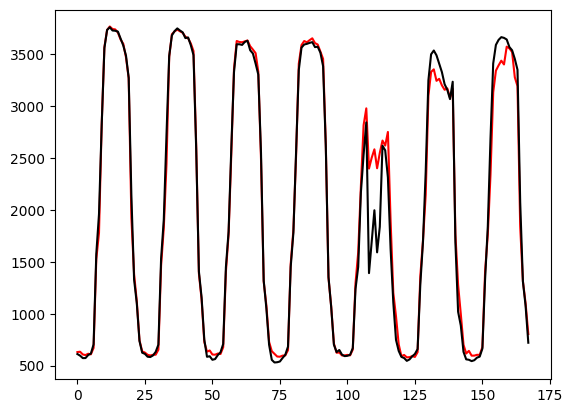

In [4]:
b_num = 39
x = pd.read_csv('./submission/submission_xgb_clust.csv')
x = x.loc[x.index[168*(b_num-1):168*b_num],'answer']
l = pd.read_csv('./submission/lightGBM_wsw_clust.csv')
l = l.loc[l.index[168*(b_num-1):168*b_num],'answer']
c = pd.read_csv('./submission/CatBoost_wsw_clust.csv')
c = c.loc[c.index[168*(b_num-1):168*b_num],'answer']
e = pd.read_csv('./submission/ensemble_lbw_clust_calculate.csv')
e = e.loc[e.index[168*(b_num-1):168*b_num],'answer']
# plt.plot(np.arange(168),x, color='m')
# plt.plot(np.arange(168),l, color='green')
# plt.plot(np.arange(168),c, color='blue')
plt.plot(np.arange(168),e, color='red')
plt.plot(np.arange(168),predictions, color='black')
plt.show()

In [7]:
compare1 = pd.read_csv('./submission\submission_autog_more15_lbw.csv')
compare2 = pd.read_csv('./submission\submission_autog54_lbw.csv')
compare = compare1['answer'] - compare2['answer']

In [19]:
# 가장 우수한 모델의 이름을 가져옵니다.
best_model_name = predictor.get_model_best()

# 가장 우수한 모델로 예측 수행
predictions = predictor.predict(test, model=best_model_name)

# 예측 결과 출력
print(predictions)


In [20]:
subm = pd.read_csv('./submission\submission_autog_more15_lbw.csv')

for idx, value in predictions.items():
    subm.loc[idx, 'answer'] = value

subm.to_csv('./submission/submission_autog_more15_lbw.csv', index = False)


In [4]:
# autog54= pd.read_csv('./submission\submission_autog54_lbw.csv')
# autog542 = pd.read_csv('./submission\submission_autog54_lbw.csv')
# new_pred =  pd.read_csv('./submission\submission_xgb_wsw_mean_all_cat.csv')



# for i in [35,39,40,41,53,54,56,58,64,75,76,87,89,91,92]:
#     k = i - 1
#     index = k*168
#     autog54[index:index+168] = new_pred[index:index+168]


# autog54.to_csv('./submission/submission_autog_mean_all.csv', index = False)

